# Object Feature Autoencoder 
#### This notebook contains the autoencoder architecture and trains the autoenocder as well. We look at the latent space of the training data, and at the PCA space representation. We mark top anomalies recovered by the autoenocder in both the training set and the held-out test set. The held out test set is representative of the databank distirbution (it's 10% of the databank). 

In [1]:
# All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot as plotly_plot
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split

## Pre-processing and scaling input data

In [2]:
# Load data 
df = pd.read_csv("ClassImbalanced_FinalTrainingSet.csv")

# Filters
filter_cols = ["dmdt_g_err","dmdt_r_err","mag_g02","mag_g08","mag_g28","mag_r02","mag_r08","mag_r28"]
for c in filter_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
mask = (
    df["dmdt_g_err"].between(-1, 1, inclusive="both") &
    df["dmdt_r_err"].between(-1, 1, inclusive="both") &
    df["mag_g02"].between(0, 30, inclusive="both") &
    df["mag_g08"].between(0, 30, inclusive="both") &
    df["mag_g28"].between(0, 30, inclusive="both") &
    df["mag_r02"].between(0, 30, inclusive="both") &
    df["mag_r08"].between(0, 30, inclusive="both") &
    df["mag_r28"].between(0, 30, inclusive="both")
)

df = df.loc[mask].reset_index(drop=True)

# Type count
type_counts = (
    df["source_label"]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "nan": pd.NA})
    .dropna()
    .value_counts()
    .sort_values(ascending=False)
)
print("Counts by transient type:")
print(type_counts.to_string())


# Build processed feature matrix
DROP_FOR_AE = [
    "ramean", "decmean", "jdmin", "ra", "decl", "g_r_days_from_fl", "glatmean",
    "jd_g_minus_r", "objectId", "classification", "catalogue_object_id",
    "classificationReliability", "tns_name", "type", "galactic_plane",
    "source_label", "dmdt_g_err", "dmdt_r_err",
    "northSeparationArcsec", "eastSeparationArcsec", "distance",
    "physical_separation_kpc",
]

df_proc = df.drop(columns=[c for c in DROP_FOR_AE if c in df.columns], errors="ignore").copy()
for c in df_proc.columns:
    df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")

df_proc = df_proc.replace([np.inf, -np.inf], np.nan)
df_proc = df_proc.fillna(df_proc.median(numeric_only=True))
num_cols = df_proc.select_dtypes(include="number").columns.tolist()


# Scale features for the autoencoder
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(df_proc[num_cols].astype(np.float32).values)


# Split indices with constraint:
# Test set must contain ONLY real objects (is_synthetic = False)
# Train/Val may contain both real and synthetic
# Target overall split: 80/10/10 (train/val/test) over the FULL filtered dataset.
if "is_synthetic" not in df.columns:
    raise ValueError("Column 'is_synthetic' not found in df. Cannot enforce real-only test split.")

is_real = (
    df["is_synthetic"]
    .astype(str)
    .str.strip()
    .str.lower()
    .isin(["false", "0", "no"])
)

idx_all = np.arange(len(df))
idx_real = idx_all[is_real.values]

n_all = len(idx_all)
n_test_target = max(1, int(np.ceil(0.10 * n_all)))

# Choose test indices only from real objects
idx_test = train_test_split(
    idx_real,
    test_size=n_test_target,
    random_state=42,
    shuffle=True
)[1] 

# Remaining indices go to train/val
idx_remain = np.setdiff1d(idx_all, idx_test, assume_unique=False)

# Val should be 10% of dataset
val_frac_of_remaining = 1.0 / 9.0
idx_train, idx_val = train_test_split(
    idx_remain,
    test_size=val_frac_of_remaining,
    random_state=42,
    shuffle=True
)

# Build arrays
X_train = X_scaled[idx_train]
X_val   = X_scaled[idx_val]
X_test  = X_scaled[idx_test]

assert np.all(is_real.iloc[idx_test].values), "Test set contains synthetic rows—split logic failed."

print("Split sizes:")
print("  train:", X_train.shape[0])
print("  val:  ", X_val.shape[0])
print("  test: ", X_test.shape[0], "(all real)")

Counts by transient type:
source_label
SN Ia      3194
SN II      3194
SN Ib/c    3194
Exotic      183
Split sizes:
  train: 7811
  val:   977
  test:  977 (all real)


# Train Autoencoder

In [3]:

# Train VAE
INPUT_DIM   = 22
HIDDEN_DIMS = [88, 56, 27]
LATENT_DIM  = 8
BATCH_SIZE  = 32
EPOCHS      = 500
BASE_LR     = 1e-3
BETA        = 0  # deterministic AE mode


class Sampling(layers.Layer):
    def __init__(self, use_noise=True, **kwargs):
        super().__init__(**kwargs)
        self.use_noise = use_noise
    def call(self, inputs):
        z_mean, z_logv = inputs
        if self.use_noise:
            eps = tf.random.normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5 * z_logv) * eps
        return z_mean

class VAE(Model):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        self.encoder = self.build_encoder(input_dim, hidden_dims, latent_dim)
        self.decoder = self.build_decoder(input_dim, hidden_dims, latent_dim)

    def build_encoder(self, input_dim, hidden_dims, latent_dim):
        inputs = layers.Input(shape=(input_dim,))
        x = inputs
        for i, units in enumerate(hidden_dims):
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.BatchNormalization()(x)
        z_mean = layers.Dense(latent_dim)(x)
        z_logv = layers.Dense(latent_dim)(x)
        z = Sampling(use_noise=(BETA > 0))([z_mean, z_logv])
        return Model(inputs, [z_mean, z_logv, z], name="encoder")

    def build_decoder(self, input_dim, hidden_dims, latent_dim):
        inputs = layers.Input(shape=(latent_dim,))
        x = inputs
        rev = list(reversed(hidden_dims))
        for i, units in enumerate(rev):
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            # Skip BN on the last hidden only
            if i < len(rev) - 1:
                x = layers.BatchNormalization()(x)
        outputs = layers.Dense(input_dim, activation='sigmoid')(x)
        return Model(inputs, outputs, name="decoder")

    def call(self, inputs):
        z_mean, z_logv, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        recon_loss = tf.reduce_mean(tf.keras.losses.huber(inputs, reconstruction, delta=1))
        self.add_loss(recon_loss)
        return reconstruction


# Cosine decay from BASE_LR to 0 over total steps (approx epochs * steps_per_epoch)
lr_schedule = CosineDecay(initial_learning_rate=BASE_LR, decay_steps=EPOCHS, alpha=0.1)

# Adam optimizer
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5, global_clipnorm=5.0)

vae = VAE(input_dim=INPUT_DIM, hidden_dims=HIDDEN_DIMS, latent_dim=LATENT_DIM)
vae.compile(optimizer=optimizer)

# Early stopping 
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=30, min_delta=1e-6, restore_best_weights=True
)

history = vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    callbacks=[es],
    batch_size=BATCH_SIZE,
    verbose=2
)

Epoch 1/500


/Users/leylaiskandarli/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning:

Gradients do not exist for variables ['dense_4/kernel', 'dense_4/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?



245/245 - 2s - 8ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 2/500
245/245 - 0s - 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/500
245/245 - 0s - 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/500
245/245 - 0s - 1ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/500
245/245 - 0s - 1ms/step - loss: 9.3243e-04 - val_loss: 8.9593e-04
Epoch 6/500
245/245 - 0s - 1ms/step - loss: 8.1360e-04 - val_loss: 7.7022e-04
Epoch 7/500
245/245 - 0s - 1ms/step - loss: 7.4668e-04 - val_loss: 7.3280e-04
Epoch 8/500
245/245 - 0s - 1ms/step - loss: 7.1923e-04 - val_loss: 7.1785e-04
Epoch 9/500
245/245 - 0s - 1ms/step - loss: 7.0584e-04 - val_loss: 6.9623e-04
Epoch 10/500
245/245 - 0s - 2ms/step - loss: 6.9393e-04 - val_loss: 6.8258e-04
Epoch 11/500
245/245 - 0s - 1ms/step - loss: 6.8675e-04 - val_loss: 6.7905e-04
Epoch 12/500
245/245 - 0s - 1ms/step - loss: 6.7785e-04 - val_loss: 6.7527e-04
Epoch 13/500
245/245 - 0s - 1ms/step - loss: 6.6946e-04 - val_loss: 6.5754e-04
Epoch 14/500
245/245 - 0s 

## Latent Space Representation (Plot used in paper)

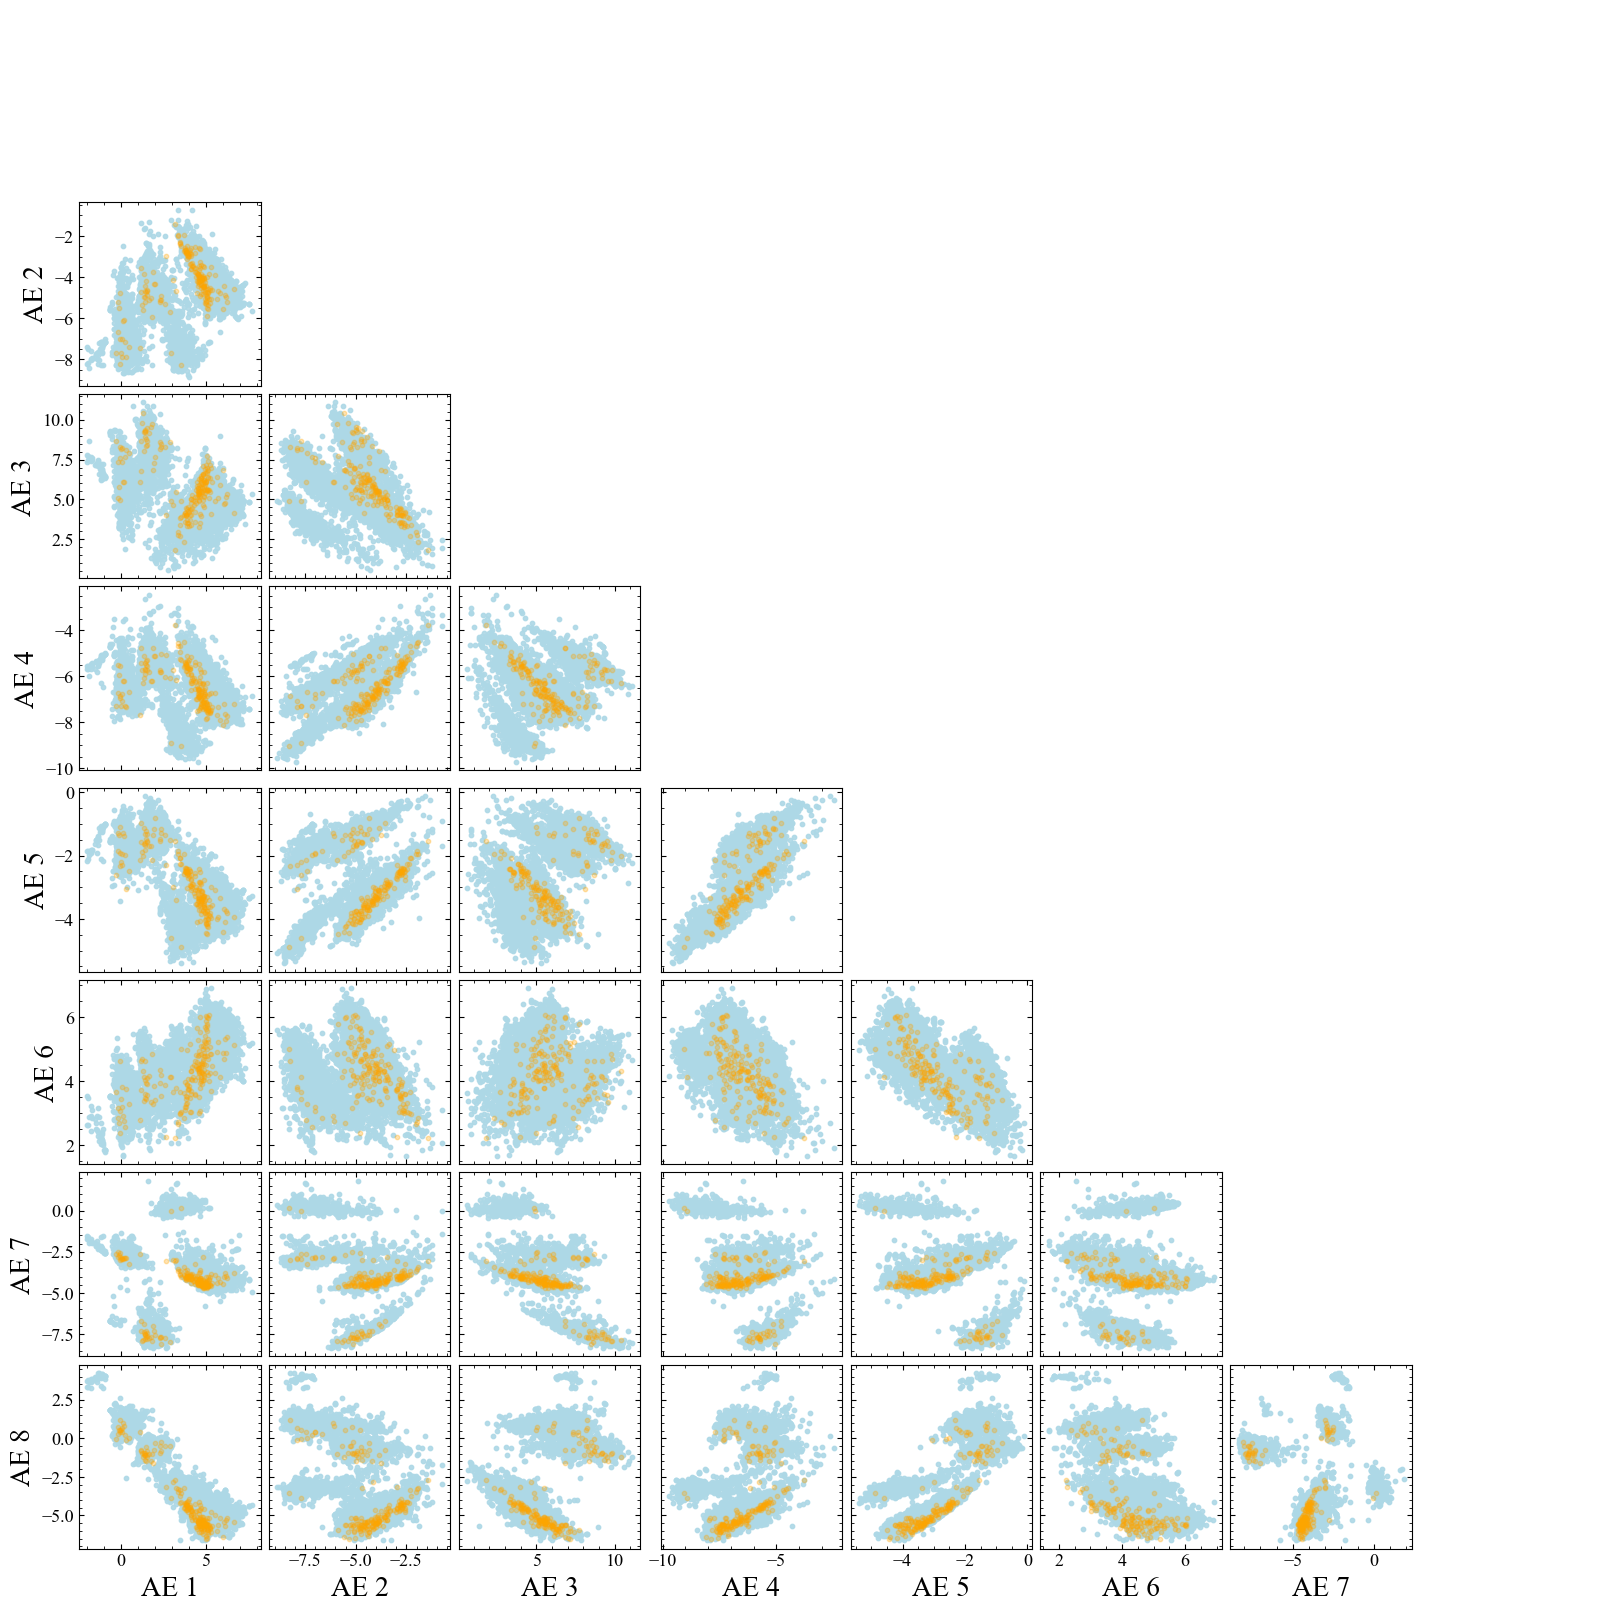

In [4]:

# Global Plot Style parameters
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.grid": False,
})

def style_axes_2d(ax):
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(False)

# Compute latent vectors
X_all = X_scaled
z_mean_all, z_logv_all, z_all = vae.encoder.predict(
    X_all, batch_size=256, verbose=0
)

labels = df["source_label"].astype(str).str.strip()
is_exotic = labels.str.lower().eq("exotic")

Z = z_mean_all
latent_dim = Z.shape[1]
assert latent_dim == LATENT_DIM

# Staircase plot
fig, axes = plt.subplots(
    latent_dim,
    latent_dim,
    figsize=(2.0 * latent_dim, 2.0 * latent_dim),
    constrained_layout=True,
)

for i in range(latent_dim):
    for j in range(latent_dim):
        ax = axes[i, j]

        if j >= i:
            ax.axis("off")
            continue
            
        ax.scatter(
            Z[~is_exotic.values, j],
            Z[~is_exotic.values, i],
            color="lightblue",
            alpha=0.9,
            s=10,
        )
        ax.scatter(
            Z[is_exotic.values, j],
            Z[is_exotic.values, i],
            color="orange",
            alpha=0.3,
            s=10,
        )
        style_axes_2d(ax)

        # Minimal labels
        if i < latent_dim - 1:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])

        if i == latent_dim - 1:
            ax.set_xlabel(f"AE {j+1}")
        if j == 0:
            ax.set_ylabel(f"AE {i+1}")

# Saving the plot
output_path = "/Users/leylaiskandarli/Desktop/LatentSpace.png"
plt.savefig(output_path, dpi=300, format="png", bbox_inches="tight", pad_inches=0.1)
plt.show()

## Plotly 3D PCA plot with entire dataset

In [5]:
# Reconstruction of all objects
X_recon = vae.predict(X_scaled, batch_size=BATCH_SIZE, verbose=0)

# Use Huber reconstruction error as anomaly score (delta=1.0), averaged over features
delta = 1.0
abs_err = np.abs(X_scaled - X_recon)
quadratic = np.minimum(abs_err, delta)
linear = abs_err - quadratic
huber_per_elem = 0.5 * (quadratic ** 2) + delta * linear
ae_errors = np.mean(huber_per_elem, axis=1)

n_samples = X_scaled.shape[0]
k = max(1, int(np.ceil(0.01 * n_samples)))  # top 1%

ae_anom_idx = np.argsort(ae_errors)[-k:]    # AE top 1% anomalies

# PCA top 1% anomalies (same k) on df_proc
X_pca_input = df_proc.copy()
X_pca_input = X_pca_input.replace([np.inf, -np.inf], np.nan)
X_pca_input = X_pca_input.fillna(X_pca_input.median())

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca_input)

pca = PCA(n_components=3, random_state=0)
X_pca = pca.fit_transform(X_pca_scaled)

mean_pca = X_pca.mean(axis=0)
pca_dists = np.linalg.norm(X_pca - mean_pca, axis=1)

pca_anom_idx = np.argsort(pca_dists)[-k:]   # PCA top 1% anomalies

# PCA anomalies
df_pca_anom = df.iloc[pca_anom_idx].copy()

# AE anomalies
df_ae_anom = df.iloc[ae_anom_idx].copy()

# Intersection of PCA & AE anomalies
pca_set = set(pca_anom_idx)
ae_set = set(ae_anom_idx)
both_idx = sorted(list(pca_set & ae_set))

df_both_anom = df.iloc[both_idx].copy()

# 3D PCA plot with color coding
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])

# Optional hover info
if "objectId" in df.columns:
    pca_df["objectId"] = df["objectId"].values
else:
    pca_df["objectId"] = np.arange(n_samples)

if "type" in df.columns:
    pca_df["type"] = df["type"].values
else:
    pca_df["type"] = None

# Label points by anomaly category
pca_df["label"] = "Normal"

pca_only_idx = list(pca_set - ae_set)
ae_only_idx = list(ae_set - pca_set)

pca_df.loc[pca_only_idx, "label"] = "PCA anomaly"
pca_df.loc[ae_only_idx, "label"] = "AE anomaly"
pca_df.loc[both_idx,       "label"] = "Both (PCA & AE)"

color_map = {
    "Normal": "lightblue",
    "PCA anomaly": "lightblue",
    "AE anomaly": "red",
    "Both (PCA & AE)": "red",
}

fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="label",
    color_discrete_map=color_map,
    hover_data=["objectId", "type"],
    title="3D PCA: PCA vs Autoencoder Top 1% Anomalies"
)

fig.update_traces(marker=dict(size=3), selector=dict(mode="markers"))
fig.update_layout(
    template="plotly_white",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

plot(fig, filename="pca_3d_pca_vs_ae_anomalies.html", auto_open=True)

NameError: name 'plot' is not defined

In [ ]:
# Plot style parameters 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 30
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.grid"] = True

# Build PCA
if "pca_df" in globals() and all(c in pca_df.columns for c in ["PC1", "PC2", "PC3"]):
    pca_df = pca_df.copy()
elif "X_pca" in globals():
    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
else:
    raise NameError("Need either `pca_df` or `X_pca`")

# Rebuild anomaly sets if needed
if "pca_set" not in globals():
    pca_set = set(map(int, pca_anom_idx)) if "pca_anom_idx" in globals() else set()

if "ae_set" not in globals():
    ae_set = set(map(int, ae_anom_idx)) if "ae_anom_idx" in globals() else set()

both_idx = sorted(pca_set & ae_set)
pca_only_idx = sorted(pca_set - ae_set)
ae_only_idx  = sorted(ae_set - pca_set)

# Ensure label column exists
pca_df["label"] = "Normal"
pca_df.loc[pca_only_idx, "label"] = "PCA anomaly"
pca_df.loc[ae_only_idx,  "label"] = "AE anomaly"
pca_df.loc[both_idx,     "label"] = "Both (PCA & AE)"

# Arrays and masks
pc1 = pca_df["PC1"].to_numpy()
pc2 = pca_df["PC2"].to_numpy()
pc3 = pca_df["PC3"].to_numpy()

red_mask  = pca_df["label"].isin(["AE anomaly", "Both (PCA & AE)"]).to_numpy()
blue_mask = ~red_mask

# Helper functions
def style_3d(ax, xlabel, ylabel, zlabel):
    ax.set_xlabel(xlabel, labelpad=18)
    ax.set_ylabel(ylabel, labelpad=18)
    ax.set_zlabel(zlabel, labelpad=12)

    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.zaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which="both", direction="in")

    ax.grid(True)
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis._axinfo["grid"]["alpha"] = 0.10
        axis._axinfo["grid"]["linewidth"] = 0.6

    try:
        ax.xaxis.pane.set_alpha(0.04)
        ax.yaxis.pane.set_alpha(0.04)
        ax.zaxis.pane.set_alpha(0.04)
    except Exception:
        pass


def scatter_two_color(ax, X, Y, Z):
    ax.scatter(
        X[blue_mask], Y[blue_mask], Z[blue_mask],
        s=10, c="lightblue", alpha=0.35,
        edgecolors="none", depthshade=False
    )
    ax.scatter(
        X[red_mask], Y[red_mask], Z[red_mask],
        s=18, c="red", alpha=0.95,
        edgecolors="none", depthshade=False
    )

# Plot
fig = plt.figure(figsize=(30, 10))  # wider figure

# Manual spacing
fig.subplots_adjust(left=0.2, right=1, bottom=0.2, top=0.97, wspace=0.02)

# Panel 1: (PC1, PC2, PC3)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
scatter_two_color(ax1, pc1, pc2, pc3)
style_3d(ax1, "PC1", "PC2", "PC3")
ax1.view_init(elev=20, azim=70)  

# Panel 2: (PC2, PC3, PC1)
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
scatter_two_color(ax2, pc2, pc3, pc1)
style_3d(ax2, "PC2", "PC3", "PC1")
ax2.view_init(elev=20, azim=70)

# Panel 3: (PC3, PC1, PC2)
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
scatter_two_color(ax3, pc3, pc1, pc2)
style_3d(ax3, "PC3", "PC1", "PC2")
ax3.view_init(elev=20, azim=70)


# Save and show
output_path = "/Users/leylaiskandarli/Desktop/PCA_Plots.png"
plt.savefig(output_path, dpi=300)
plt.show()

# Test Set evaluation

In [ ]:
X_test_recon = vae.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

# Use Huber reconstruction error as anomaly score (delta=1.0), averaged over features
delta = 1.0
abs_err = np.abs(X_test - X_test_recon)
quadratic = np.minimum(abs_err, delta)
linear = abs_err - quadratic
huber_per_elem = 0.5 * (quadratic ** 2) + delta * linear
ae_test_errors = np.mean(huber_per_elem, axis=1)

n_test = X_test.shape[0]
k_test = max(1, int(np.ceil(0.01 * n_test)))  # top 1% within TEST
anom_test_local_idx = np.argsort(ae_test_errors)[-k_test:]
anom_test_global_idx = idx_test[anom_test_local_idx]

# Save full original rows for the anomalous test objects
df_test_anom_full = df.iloc[anom_test_global_idx].copy()
output_csv = "AE_test_top1pct_anomalies_full_features.csv"
df_test_anom_full.to_csv(output_csv, index=False)

# 3D PCA of test set only
X_test_proc = df_proc.iloc[idx_test].copy()

# Standardize for PCA
scaler_pca = StandardScaler()
X_test_proc_scaled = scaler_pca.fit_transform(X_test_proc[num_cols].values)

pca = PCA(n_components=3, random_state=0)
X_test_pca = pca.fit_transform(X_test_proc_scaled)

# Colors: blue for normal, red for anomalies
is_anom = np.zeros(n_test, dtype=bool)
is_anom[anom_test_local_idx] = True
colors = np.where(is_anom, "red", "lightblue")

# Hover fields
hover_objid = df["objectId"].iloc[idx_test].values if "objectId" in df.columns else idx_test
hover_type  = df["type"].iloc[idx_test].values if "type" in df.columns else np.array([None] * n_test)

fig = go.Figure(
    data=go.Scatter3d(
        x=X_test_pca[:, 0],
        y=X_test_pca[:, 1],
        z=X_test_pca[:, 2],
        mode="markers",
        marker=dict(size=4, color=colors, opacity=0.9),
        text=[f"objectId={o}<br>type={t}<br>AE_err={e:.3e}" for o, t, e in zip(hover_objid, hover_type, ae_test_errors)],
        hoverinfo="text",
    )
)

fig.update_layout(
    title="3D PCA of TEST Set Only (Real Objects) — AE Top 1% Anomalies in Red",
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"),
    margin=dict(l=0, r=0, b=0, t=50)
)

plot(fig, filename="AE_test_top1pct_anomalies_pca3d.html", auto_open=True)